In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
import os
from torchvision import datasets, transforms
import torch
from model import Net
import albumentations as A
from data_augment import ParseAnno
from create_dataset import DataGeneratorRCNN
import torch.optim as optim
import torch.nn as nn
import numpy as np
from torchvision.ops import batched_nms

In [5]:
os.chdir('/content/drive/MyDrive/CS5242/Project')

In [9]:
#Apply Augmentations to base images
#Store all your base images in 'data' and annotations in 'annotations'

class_to_id = {'burger': 1, 'drinks': 2, 'fries': 3}
parser = ParseAnno('annotations', class_to_id, 'data')
parser.parse()

#Add more augmentations from albumentations if you feel like it
parser.augment([A.HorizontalFlip(), A.RandomBrightnessContrast()])
parser.final_dataframe.to_csv(os.getcwd()+'/df2.csv')

In [11]:
#Crops the IOUs and stores it in the 'dataset' folder

id_to_label = {1: 'burger', 2: 'drinks', 3: 'fries', 0: 'background'}
data_gen = DataGeneratorRCNN(id_to_label, 'data', 'df2.csv')
data_gen.convert_csv()
data_gen.create()

In [13]:
BATCH_SIZE = 32

#Creating a dataloader for the 'dataset' folder

dataset = datasets.ImageFolder('./dataset/', transform=transforms.Compose([transforms.ToTensor(),  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

#Change this to a better model
net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [14]:
for epoch in range(10):

    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


In [15]:
from utils import *

#Generate 2000 proposals from the selective search algorithm

image = read_image_cv2('/content/drive/MyDrive/IMG_20221010_172101.jpg')
ss_boxes = get_ss_boxes(image)
ss_boxes = ss_boxes[:2000]


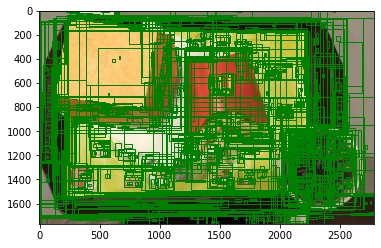

In [16]:
plot_image_with_bb(image, ss_boxes)

In [17]:
import cv2
size = (224, 224)
proposals = []
boxes = []

for (x1, y1, x2, y2, label) in ss_boxes:
  img = image[y1:y2, x1:x2]
  img = cv2.resize(img, size, interpolation=cv2.INTER_CUBIC)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  proposals.append(img)
  boxes.append((x1, y1, x2, y2))


In [19]:
#Make the model predict on all the 2000 proposals

proposals = torch.Tensor(proposals).permute(0, 3, 1, 2)
boxes = torch.Tensor(boxes)
proba = net(proposals)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
#Apply Non-max suppression on the predictions

scores, idxs = torch.max(proba, dim=1)
i = batched_nms(boxes, scores, idxs, 0.05)
kept_boxes = boxes[i]
new_idxs = idxs[i]

kept_boxes = torch.cat((kept_boxes, new_idxs[:, None]), dim=1)

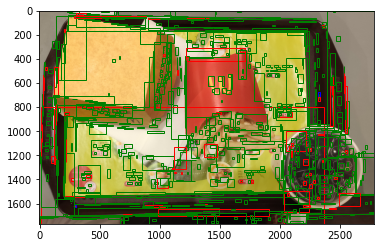

In [21]:
#See the final output

id_to_color = {1: 'r', 2: 'y', 3:'b', 0: 'g'}
fig, ax = plt.subplots()
ax.imshow(image)
for bbox in kept_boxes:
    xmin, ymin, xmax, ymax, label = bbox
    rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor=id_to_color[int(label)], facecolor='none')
    ax.add_patch(rect)

plt.show()